>## Preprocess

In [75]:
## library import
import os
import cv2

from keras.layers import Conv2D, Input, Activation
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

def fn_makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise

In [76]:
## 데이터를 가져올 경로 설정.
base_path = 'D:\OneDrive - Siemens Healthineers\\1_External Training\\2_Python\VScode\Jupyter_notebook\\7_Brad\\1_Super_Resolution\data'
print(base_path)

img_path = os.path.join(base_path, 'img_align_celeba')
print(img_path)
target_path = os.path.join(base_path, 'processed')
print(target_path)

## makedir for processed
fn_makedirs(os.path.join(target_path, 'X_train'))
fn_makedirs(os.path.join(target_path, 'y_train'))
fn_makedirs(os.path.join(target_path, 'X_val'))
fn_makedirs(os.path.join(target_path, 'y_val'))
fn_makedirs(os.path.join(target_path, 'X_test'))
fn_makedirs(os.path.join(target_path, 'y_test'))

D:\OneDrive - Siemens Healthineers\1_External Training\2_Python\VScode\Jupyter_notebook\7_Brad\1_Super_Resolution\data
D:\OneDrive - Siemens Healthineers\1_External Training\2_Python\VScode\Jupyter_notebook\7_Brad\1_Super_Resolution\data\img_align_celeba
D:\OneDrive - Siemens Healthineers\1_External Training\2_Python\VScode\Jupyter_notebook\7_Brad\1_Super_Resolution\data\processed


In [77]:
img_file_list = np.loadtxt(os.path.join(base_path, 'list_eval_partition.csv'), dtype=str, delimiter=',', skiprows=1)
print(img_file_list[:5])

[['000001.jpg' '0']
 ['000002.jpg' '0']
 ['000003.jpg' '0']
 ['000004.jpg' '0']
 ['000005.jpg' '0']]


In [78]:
## 정사각형으로 이미지 자르기.
sample = cv2.imread(os.path.join(img_path, img_file_list[0][0]))
h, w, _ = sample.shape
print(h, w)

218 178


(178, 178, 3)


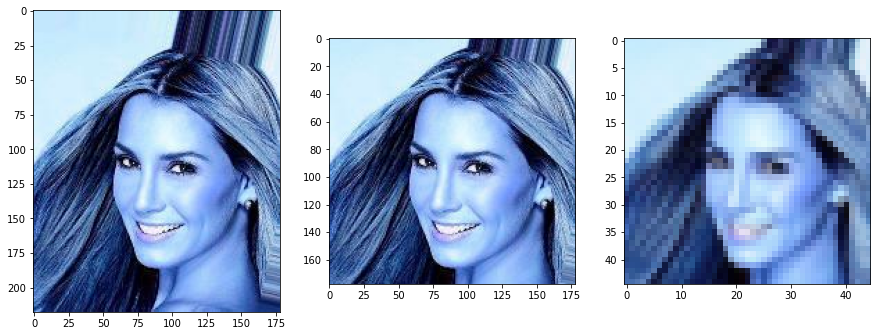

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
plt.imshow(sample)

## 정사각형으로 이미지 자르기
crop_sample = sample[int((h-w)/2):int(-(h-w)/2), :]
print(crop_sample.shape)
plt.subplot(1, 3, 2)
plt.imshow(crop_sample)

## 정사각형 이미지를 pyramid_reduce를 통해서 downscale한다.
from skimage.transform import pyramid_reduce
down_sample = pyramid_reduce(crop_sample, downscale=4, multichannel=True)
plt.subplot(1, 3, 3)
plt.imshow(down_sample)

In [70]:
## 전략적인 부분은...
## 1) input image: down_sample file으로 집어넣고
## 2) target image: crop_sample file으로 집어넣어서 fit.
## 100개 파일을 가지고 훈련해볼까나.

for image, label in enumerate(img_file_list):
    
    ## label[0] => [filename.확장자] 로 되어 있는 부분을 [filename]과 [확장자]로 구분.
    filename, ext = os.path.splitext(label[0])
        
    load_img = os.path.join(img_path, label[0])
    img = cv2.imread(load_img)
    
    crop = img[int((h-w)/2):int(-(h-w)/2), :]
    
    ## 자른 이미지를 176 x 176 으로 resize
    crop = cv2.resize(crop, dsize=(176, 176))
    down_img = pyramid_reduce(crop, downscale=4)
    
    norm = cv2.normalize(crop.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)
    
    
    ## training data
    if int(label[1]) == 0:
        np.save(os.path.join(target_path, 'X_train', filename + '.npy'), down_img)
        np.save(os.path.join(target_path, 'y_train', filename + '.npy'), norm)
    elif int(label[1]) == 1:
        np.save(os.path.join(target_path, 'X_val', filename + '.npy'), down_img)
        np.save(os.path.join(target_path, 'y_val', filename + '.npy'), norm)
    elif int(label[1]) == 2:
        np.save(os.path.join(target_path, 'X_test', filename + '.npy'), down_img)
        np.save(os.path.join(target_path, 'y_test', filename + '.npy'), norm)

>## Training

In [74]:
## import library
from tensorflow import keras
from keras.models import Model
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

D:\OneDrive - Siemens Healthineers\1_External Training\2_Python\VScode\Jupyter_notebook\7_Brad\1_Super_Resolution\data\processed
40 40


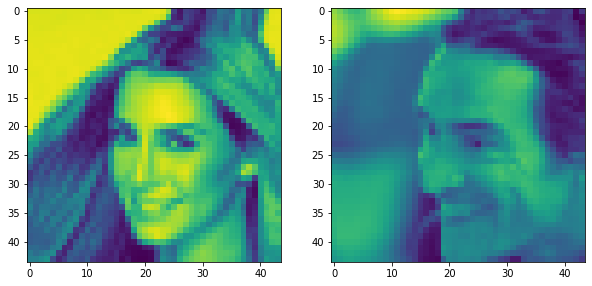

In [84]:
## train data load
import glob

print(target_path)

X_train_list = sorted(glob.glob(os.path.join(target_path, 'X_train', '*.npy')))
X_val_list = sorted(glob.glob(os.path.join(target_path, 'X_val', '*.npy')))

print(len(X_train_list), len(X_val_list))

## Downsample된 image 데이터 확인하기.
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.load(X_train_list[0]))

plt.subplot(1, 2, 2)
plt.imshow(np.load(X_val_list[0]))

>## 미니 배치 단위로 데이터를 생성하기

In [85]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.dim[0] * 4, self.dim[1] * 4, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i] = np.load(ID)

            splited = ID.split('/')
            splited[-2] = 'y' + splited[-2][1:] # x_train -> y_train
            y_path = os.path.join(os.sep, *splited)

            # Store class
            y[i] = np.load(y_path)

        return X, y

In [86]:
train_gen = DataGenerator(list_IDs=X_train_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=True)
val_gen = DataGenerator(list_IDs=X_val_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=False)

In [91]:
from keras import backend as K
from keras.layers import Conv2D

"""
	Subpixel Layer as a child class of Conv2D. This layer accepts all normal
	arguments, with the exception of dilation_rate(). The argument r indicates
	the upsampling factor, which is applied to the normal output of Conv2D.
	The output of this layer will have the same number of channels as the
	indicated filter field, and thus works for grayscale, color, or as a a
	hidden layer.
	Arguments:
		*see Keras Docs for Conv2D args, noting that dilation_rate() is removed*
		r: upscaling factor, which is applied to the output of normal Conv2D
	A test is included, which performs super-resolution on the Cifar10 dataset.
	Since these images are small, only a scale factor of 2 is used. Test images
	are saved in the directory 'test_output/'. This test runs for 5 epochs,
	which can be altered in line 132. You can run this test by using the
	following commands:
	mkdir test_output
	python keras_subpixel.py
"""


class Subpixel(Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 r,
                 padding='valid',
                 data_format=None,
                 strides=(1,1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Subpixel, self).__init__(
            filters=r*r*filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.r = r

    def _phase_shift(self, I):
        r = self.r
        bsize, a, b, c = I.get_shape().as_list()
        bsize = K.shape(I)[0] # Handling Dimension(None) type for undefined batch dim
        X = K.reshape(I, [bsize, a, b, int(c/(r*r)),r, r]) # bsize, a, b, c/(r*r), r, r
        X = K.permute_dimensions(X, (0, 1, 2, 5, 4, 3))  # bsize, a, b, r, r, c/(r*r)
        #Keras backend does not support tf.split, so in future versions this could be nicer
        X = [X[:,i,:,:,:,:] for i in range(a)] # a, [bsize, b, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, b, a*r, r, c/(r*r)
        X = [X[:,i,:,:,:] for i in range(b)] # b, [bsize, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, a*r, b*r, c/(r*r)
        return X

    def call(self, inputs):
        return self._phase_shift(super(Subpixel, self).call(inputs))

    def compute_output_shape(self, input_shape):
        unshifted = super(Subpixel, self).compute_output_shape(input_shape)
        return (unshifted[0], self.r*unshifted[1], self.r*unshifted[2], int(unshifted[3]/(self.r*self.r)))

    def get_config(self):
        config = super(Conv2D, self).get_config()
        # config.pop('rank')
        # config.pop('dilation_rate')
        config['filters'] = int(config['filters'] / (self.r*self.r))
        config['r'] = self.r
        return config

>## Modeling

In [94]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"

70763455/70763455 [==============================] - 12s 0us/step


In [96]:
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

print(data_dir, root_dir)

C:\Users\sel04327\.keras\datasets\BSR C:\Users\sel04327\.keras\datasets\BSR\BSDS500/data
